In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv(override=True)

True

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

In [5]:
import nest_asyncio
nest_asyncio.apply()

In [6]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)

tools = toolkit.get_tools()

In [7]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/soroushav/Library/Caches/ms-playwright/chromium-1187/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=140.0.7339.16>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/soroushav/Library/Caches/ms-playwright/chromium-1187/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=140.0.7339.16>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/soroushav/Library/Caches/ms-playwright/chromium-1187/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=140.0.7339.16>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/soroushav/Library/Caches/ms-playwright/chromium-1187/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=140.0.7339.16>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/soroushav/Library/Caches/ms-pl

In [8]:
tools_by_name = {tool.name: tool for tool in tools}
navigate_browser_tool = tools_by_name.get("navigate_browser")
extract_text_tool = tools_by_name.get("extract_text")

await navigate_browser_tool.arun({"url": "https://www.udemy.com"})
text = await extract_text_tool.arun({})

In [9]:
import textwrap
print(textwrap.fill(text))

Online Courses - Learn Anything, On Your Schedule | Udemy Ends in
11h 37m 10s . Deal of the day | Buy a course and get a free 7-day
trial of Personal Plan. Terms apply . Skip to content Explore Explore
by Goal Learn AI Launch a new career Prepare for a certification
Practice with Role Play Development Business Finance & Accounting IT &
Software Office Productivity Personal Development Design Marketing
Lifestyle Photography & Video Health & Fitness Music Teaching &
Academics Search for anything Plans & Pricing Udemy Business Get your
team access to over 30,000 top Udemy courses, anytime, anywhere. Try
Udemy Business Teach on Udemy Turn what you know into an opportunity
and reach millions around the world. Learn more Log in Sign up English
العربية Deutsch Español Français Bahasa Indonesia Italiano 日本語 한국어
Nederlands Polski Português Română Русский ภาษาไทย Türkçe Tiếng Việt
中文(简体) 中文(繁體) Development Web Development Data Science Mobile
Development Programming Languages Game Development Dat

In [12]:
all_tools = tools + [tool_push]

In [13]:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


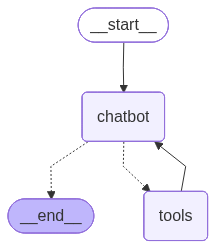

In [14]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
config = {"configurable": {"thread_id": "19"}}

async def chat(user_input:str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
